<a href="https://colab.research.google.com/github/TomTec94/FaceRecognitionModel/blob/main/V3_FaceRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Major literature source: PyTorch Pocket Reference by Joe Papa

**Structure of this Notebook:**


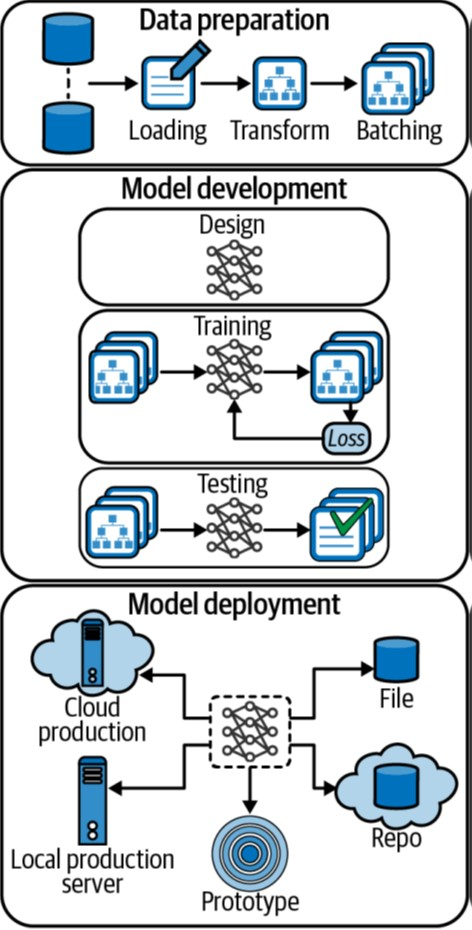

**Task of this Model**: Implementation of a tool that is able to detect the emotional states based on the facial expression of a person in a picture.

# 1. Data Preparation

Mount Google Drive to get the the Fer2013 Dataset

## 1.1 Set up of the Environment

In [ ]:
#Connect GoogleDrive
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
#if necessary
#!pip install Torch and Pandas
#!pip install torch torchvision
#!pip install pandas
#!pip install matplotlib
#!pip install torchviz
#!pip install tensorboard
!pip install lightning

In [ ]:
# Collection of needed modules

# Standard library imports
import os
from datetime import datetime

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Lightning imports
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Optional import (commented out)
# from torchviz import make_dot

## 1.2 Pre Data manipulation

Pre data manipulation of the input dataset (Fer2013.csv)

Source: https://www.kaggle.com/datasets/nicolejyt/facialexpressionrecognition



Drop unneeded facial emotions

In [ ]:
import pandas as pd

def drop_and_remap_emotions(data: pd.DataFrame, emotions_to_remove: list[int], emotion_mapping: dict[int, int]) -> pd.DataFrame:
    """
    Drops specified emotions from the dataset and remaps the remaining emotions.

    Args:
        data (pd.DataFrame): The original dataset containing facial emotion data.
        emotions_to_remove (list[int]): List of emotions to be removed.
        emotion_mapping (dict[int, int]): Mapping of remaining emotions to new labels.

    Returns:
        pd.DataFrame: The trimmed and remapped dataset.
    """
    # Drop the unneeded emotions
    trimmed_data = data[~data['emotion'].isin(emotions_to_remove)]

    # Apply the mapping to the 'emotion' column
    trimmed_data['emotion'] = trimmed_data['emotion'].map(emotion_mapping)

    return trimmed_data

# Path to the fer2013.csv
csv_file = '/content/drive/MyDrive/Fer_Dataset/fer2013.csv'
data = pd.read_csv(csv_file)

# Define emotions to be removed and the new mapping for the remaining emotions
emotions_to_remove = [1, 2, 5]
emotion_mapping = {
    0: 0,  # Angry stays 0
    3: 1,  # Happy becomes 1
    4: 2,  # Sad becomes 2
    6: 3   # Neutral becomes 3
}

# Drop and remap emotions
trimmed_data = drop_and_remap_emotions(data, emotions_to_remove, emotion_mapping)

# Save the trimmed and remapped data to a new CSV
trimmed_data.to_csv('fer2013_trimmed.csv', index=False)



## 1.3 Data Loading

You do not have to perform the 1.2 pre data manipulation if you want
to start with the fer2013_trimmed_5000_mapped.csv dataset (can be downloaded
from the github)

In [ ]:
# read/import the manipuleted dataset from step 1.2
data = pd.read_csv('/content/drive/MyDrive/Fer_Dataset/fer2013_trimmed.csv')



Basic first exploratiom of the dataset

In [ ]:
print(data)

In [ ]:
# show the shape of the DataFrame
print(data.shape)
print(data.columns)

In [ ]:
# give the number of pictures for the different usages
print('Complete Dataset: ',len(data))
print('Training: ', len(data[data['Usage'] == 'Training']))
print('Publicteset: ', len(data[data['Usage'] == 'PublicTest']))
print('Privatetest: ', len(data[data['Usage'] == 'PrivateTest']))

## 1.4 Transform Data
Covert the Dataframe to tensor for further usage


*   save emotions in a list as tensor
*   save images in a list as tensor
  * split the pixel values
  * reshape to 48 x 48
  * normalize the pixel values



In [ ]:
import torch
import pandas as pd
from typing import Tuple

def prepare_data(data: pd.DataFrame) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepares the data for model training by converting pixel values into tensors and normalizing them.

    Args:
        data (pd.DataFrame): The dataset containing 'emotion' and 'pixels' columns.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image tensor (X) and the labels tensor (y).
    """
    X = []
    y = torch.tensor(data['emotion'].values, dtype=torch.long)

    for pix in data['pixels']:
        # Use the torch function to convert arrays to tensors
        pixels = torch.tensor([float(p) for p in pix.split()], dtype=torch.float32)
        image = pixels.view(48, 48)  # Manipulate shape
        X.append(image)

    # Stack count of images
    X = torch.stack(X)

    # Normalize the picture
    X = X / 255.0

    return X, y

# Call of the function if needed (uncomment)
'''
# X, y = prepare_data(data)
# print(X.shape)
# print(type(X))
# print(y.shape)
'''


'\n#X, y = prepare_data(data)\nprint(X.shape)\nprint(type(X))\nprint(y.shape)\n'

Show sample picture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Union

# Show sample picture with label
# X, y = prepare_data(data)

# Function to show image
def show_tensor_image(tensor_image: torch.Tensor, label: Union[int, torch.Tensor]) -> None:
    """
    Displays a given tensor image with its corresponding label.

    Args:
        tensor_image (torch.Tensor): The image tensor to be displayed.
        label (Union[int, torch.Tensor]): The label corresponding to the image.
    """
    tensor_image = tensor_image.squeeze(0)
    image = tensor_image.cpu().numpy()

    # Emotion Mapping
    emotion_mapping = {
        0: 'Angry',
        1: 'Happy',
        2: 'Sad',
        3: 'Neutral'
    }

    # Convert label to emotion
    emotion_label = emotion_mapping.get(label, "Unknown")

    # Display image with label as title
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {emotion_label}")
    plt.axis('off')
    plt.show()

# Random picture
random_pic = np.random.randint(0, len(X))
sample_image = X[random_pic]
sample_label = y[random_pic].item()

show_tensor_image(sample_image, sample_label)
print(sample_label)




Set up a transorms.Compose which lists a sequence of datatransfor steps for training and test data

In [ ]:
# Set up a transforms.Compose with a sequence of datatransform steps

# set sequence of transforms of the traindataset
train_transforms = transforms.Compose([
  transforms.RandomRotation(10),
  transforms.Normalize(
    mean=(0.5),
    std=(0.5))])


# set sequence of transforms of the testdataset
test_transforms = transforms.Compose([
  transforms.Normalize(
    mean=(0.5),
    std=(0.5))])

Split the Dataset in train-, test- and validation-data

In [ ]:
# use the fer2013_trimmed.csv dataset as data
# data = pd.read_csv('/content/fer2013_trimmed.csv')

# Training-Data
train_data = data[data['Usage'] == 'Training']
X_train, y_train = prepare_data(train_data)

# Test-Data
public_test_data = data[data['Usage'] == 'PublicTest']
X_test, y_test = prepare_data(public_test_data)

# validation-Data
private_test_data = data[data['Usage'] == 'PrivateTest']
X_val, y_val = prepare_data(private_test_data)

In [ ]:
# check data splitting
print(train_data.shape)
print(train_data)
print(X_train.shape)
print(y_train.shape)
print(y_train)
print(public_test_data.shape)
print(private_test_data.shape)

## 1.5 Data Batching

In [ ]:
# Creation of a Dataloader for train_data
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

# Creation of a Dataloader for test_data
test_loader = DataLoader(
    public_test_data,
    batch_size=16,
    shuffle=True)


# 2. Model Development

Base ist the PyTorch NN module after some basic research this seems to be a good base. The use of a pretrained model semms to be boring

## 2.1 Model Creation

In [ ]:
import torch
from torch.utils.data import Dataset
from typing import Callable

class Fer2013Dataset(Dataset):
    """
    A custom PyTorch Dataset for the FER2013 dataset.

    Args:
        images (torch.Tensor): A tensor containing the images.
        labels (torch.Tensor): A tensor containing the labels.
        transform (Callable, optional): A function/transform to apply to the images.
    """
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, transform: Callable = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        """Returns the length of the dataset."""
        return len(self.labels)

    def __getitem__(self, idx: int):
        """
        Retrieves the image and label at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the transformed image and the label.
        """
        image = self.images[idx]
        image = torch.unsqueeze(image, 0)  # Add a dimension
        label = self.labels[idx].long()

        if self.transform:
            image = self.transform(image)

        return image, label



In [ ]:
#create the dataset for training and test
train_dataset = Fer2013Dataset(X_train, y_train, transform=train_transforms)
test_dataset = Fer2013Dataset(X_test, y_test, transform=test_transforms)

# create the loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


Define model paramters at one point for easy central adjustments

In [ ]:
# Model Parameters
NUM_CLASSES = 4          # number of emotions
INPUT_CHANNELS = 1       # number of input channels (1, since gray)
KERNEL_SIZE = 3          # Kernel size of conv-layer
HIDDEN_UNITS = 128       # in fc-layer
DROPOUT_RATE = 0.3       # dropout rate to prevent overfitting


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FaceRecModel(nn.Module):
    """
    A Convolutional Neural Network (CNN) model for face recognition.

    The model consists of multiple convolutional layers followed by max pooling, batch normalization,
    fully connected layers, and dropout for regularization.
    """
    def __init__(self):
        super(FaceRecModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(INPUT_CHANNELS, 32, kernel_size=KERNEL_SIZE, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=KERNEL_SIZE, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=KERNEL_SIZE, padding=1)
        # Max Pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Batch Normalization Layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 6 * 6, HIDDEN_UNITS)
        self.fc2 = nn.Linear(HIDDEN_UNITS, NUM_CLASSES)
        # Dropout (to prevent overfitting)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor representing the batch of images.

        Returns:
            torch.Tensor: The output logits for each class.
        """
        # Convolutional Layers with ReLU, Pooling, and Batch Normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Flatten the image for the fully connected layer
        x = x.view(x.size(0), -1)
        # Fully Connected Layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
!pip install torchinfo
from torchinfo import summary
model = FaceRecModel()
summary(model, input_size=(BATCH_SIZE, 1, 48, 48))

In [ ]:

example_input = torch.randn(1, 1, 48, 48).to(device)
output = model(example_input)
make_dot(output, params=dict(model.named_parameters()))



## 2.2 Model Training and iterative Optimization

General set up

In [ ]:
# General set-ups

# Define where the model should be saved
drive_path = '/content/drive/MyDrive/modelruns/'

# Define where the logging of the modeltraining is saved
log_dir = os.path.join(drive_path, 'tensorboard_logs')

model_save_path = '/content/drive/MyDrive/modelruns/saved_models'

# Create folder if not already existing
os.makedirs(log_dir, exist_ok=True)

# Check the use of GPU if available
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Define model paramters at one point for easy central adjustments

In [ ]:
# Training Parameters
LEARNING_RATE = 0.001  # learning rate
BATCH_SIZE = 64         # batch-size
N_EPOCHS = 100           # number of epochs for training
MOMENTUM = 0.9           # Momentum for SGD Optimizer
PATIENCE_COUNT = 6       # Early Stopping patience
LABEL_SMOOTHING = 0.1    # Label smoothing for cross-entropy loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os

# Model and hyperparameters
model = FaceRecModel().to(device)

# Define loss function and model optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True, min_lr=1e-6)

# TensorBoard log
run_name = f"Run_{datetime.now().strftime('%Y%m%d_%H%M%S')}_lr{LEARNING_RATE}_mom{MOMENTUM}"
log_dir = os.path.join(drive_path, 'tensorboard_logs', run_name)
writer = SummaryWriter(log_dir=log_dir)

# Logging Model Parameters, Optimizer, Scheduler, and Criterion
hparams = {
    'learning_rate': LEARNING_RATE,
    'momentum': MOMENTUM,
    'batch_size': BATCH_SIZE,
    'num_epochs': N_EPOCHS,
    'kernel_size': KERNEL_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'hidden_units': HIDDEN_UNITS,
    'patience_count': PATIENCE_COUNT,
    'label_smoothing': LABEL_SMOOTHING,
    'optimizer': optimizer.__class__.__name__,  # Log optimizer class
    'scheduler': scheduler.__class__.__name__,  # Log scheduler class
    'criterion': criterion.__class__.__name__,  # Log criterion class
}



Save the Model

In [ ]:
import torch
import os
from datetime import datetime
from typing import Union

# Function to save the model after training
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss: Union[float, torch.Tensor], model_save_path: str) -> None:
    """
    Saves the model and optimizer state after training.

    Args:
        model (torch.nn.Module): The trained model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer used during training.
        loss (Union[float, torch.Tensor]): The final loss value to include in the saved file name.
        model_save_path (str): The directory path where the model should be saved.
    """
    time_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"model_final_loss{loss:.4f}_{time_stamp}.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, os.path.join(model_save_path, model_name))
    print(f"Model saved as {model_name}")



**Create training loop**

*Additonal features*
*   implementation of tqdm for pregress monitoring
*   implementation of the TensorBoard logs to montor model performance during training



In [ ]:
import torch
from torch.utils.data import DataLoader
from typing import Tuple

# Function for testing/evaluation
# Has to be executed before model training !!!
def evaluate_model(model: torch.nn.Module, test_loader: DataLoader, criterion: torch.nn.Module) -> Tuple[float, float]:
    """
    Evaluates the model on the test dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        Tuple[float, float]: A tuple containing the average test loss and accuracy.
    """
    model.eval()  # Set to evaluation mode
    test_loss = 0.0
    num_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            num_correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    accuracy = num_correct / total
    return avg_test_loss, accuracy




In [ ]:
import torch
from tqdm import tqdm

# Early Stopping Parameters
patience = PATIENCE_COUNT  # Number of epochs without improvement before stopping
best_loss = float('inf')  # Stores the best test loss
patience_counter = 0  # Counts epochs without improvement

# Training Loop
for epoch in range(N_EPOCHS):
    correct_predictions = 0
    total_predictions = 0
    epoch_loss = 0.0

    model.train()  # Set model to training mode

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{N_EPOCHS}") as pbar:
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            pbar.update(1)

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Loss: {avg_epoch_loss:.6f}")

    # Evaluate on the test set
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.2f}")

    # TensorBoard logs for each epoch
    writer.add_scalar('Loss/train', avg_epoch_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)
        writer.add_histogram(f'{name}.grad', param.grad, epoch)

    scheduler.step(test_loss)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning rate after epoch {epoch + 1}: {current_lr}")

    # Early Stopping Logic
    if test_loss < best_loss:
        best_loss = test_loss  # Update the best test loss
        patience_counter = 0  # Reset the patience counter
    else:
        patience_counter += 1  # Increment the patience counter
        print(f"No improvement in test loss for {patience_counter} epoch(s).")

        # Stop training if patience is reached
        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement for {patience} consecutive epochs.")
            break

# After training is done, log hyperparameters with final metrics
final_metrics = {
    'train_loss': avg_epoch_loss,
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
}

# Log hyperparameters and final metrics
writer.add_hparams(hparams, final_metrics)

# Save model after training is completed in Google Drive
save_model(model, optimizer, avg_epoch_loss, model_save_path)

# Close the TensorBoard writer
writer.close()




Save model after Training run

In [ ]:
# Save model after training is completed in Google Drive
save_model(model, optimizer, avg_epoch_loss, model_save_path)

# Close the TensorBoard writer
writer.close()


Set up Tensorboard for monitoring of the different Trainingloops

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/modelruns/tensorboard_logs

## 2.3 Model Testing


Evaluation/Testing of the model with the best Perfomance

Based on the metrics provided, the model with the following metrics appears to be the best:

**Modelrun**:model_final_loss0.7954_20241020_131212.pth





In [ ]:
import random

Load the chosen model for further usage

In [ ]:
# load specific model in test model
model_path = '/content/drive/MyDrive/modelruns/saved_models/best_model.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print('Model loaded successfully and ready for further use.')

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader
from typing import Tuple, List, Union

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model in eval-mode
def evaluate_model(model: torch.nn.Module, test_loader: DataLoader, criterion: torch.nn.Module) -> Tuple[List[int], List[int], float, float]:
    """
    Evaluates the model on the test dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        Tuple[List[int], List[int], float, float]:
            A tuple containing:
            - List of true labels (all_labels)
            - List of predicted labels (all_predictions)
            - Accuracy of the model on the test set
            - Average loss on the test set
    """
    model.eval()
    model.to(device)
    test_loss = 0.0
    correct_predictions = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    return all_labels, all_predictions, accuracy, avg_test_loss

# Model needs to be loaded first!!!
all_labels, all_predictions, test_accuracy, test_loss = evaluate_model(model, test_loader, criterion)




In [ ]:
# Emotion mapping
emotion_mapping = {
    0: 'Angry',
    1: 'Happy',
    2: 'Sad',
    3: 'Neutral'
}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List

# Create confusion matrix
def plot_confusion_matrix(all_labels: List[int], all_predictions: List[int], emotion_mapping: dict[int, str]) -> None:
    """
    Plots a confusion matrix for emotion recognition.

    Args:
        all_labels (List[int]): True labels of the test dataset.
        all_predictions (List[int]): Predicted labels by the model.
        emotion_mapping (dict[int, str]): Mapping of emotion indices to emotion names.
    """
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Labeling matrix
    emotion_labels = [emotion_mapping[i] for i in range(len(emotion_mapping))]

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title("Confusion Matrix for Emotion Recognition")
    plt.xlabel("Predicted Emotion")
    plt.ylabel("True Emotion")
    plt.show()

# Example usage
# plot_confusion_matrix(all_labels, all_predictions, emotion_mapping)



In [ ]:
from sklearn.metrics import classification_report

emotion_labels = [emotion_mapping[i] for i in range(len(emotion_mapping))]

# create report
class_report = classification_report(all_labels, all_predictions, target_names=emotion_labels)
print(class_report)


In [ ]:
import random
import matplotlib.pyplot as plt

# Fuction to show predictions of 6 test images
def show_predictions_grid_random_fixed(model, test_loader, num_images=6):
    model.eval()

    #create an empty list for images and labels
    all_inputs = []
    all_labels = []

    for inputs, labels in test_loader:
        all_inputs.append(inputs)
        all_labels.append(labels)

    #merge tensors
    all_inputs = torch.cat(all_inputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # random choice
    indices = random.sample(range(all_inputs.size(0)), num_images)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for i, idx in enumerate(indices):
        inputs = all_inputs[idx].unsqueeze(0).to(device)
        true_label = all_labels[idx].item()

        # Model prediction
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

        # get picture
        image = inputs.cpu().squeeze().numpy()

        # print label (true and prediction)
        true_emotion = emotion_mapping[true_label]
        predicted_emotion = emotion_mapping[predicted_label]

        # fix label position
        row = i // 3
        col = i % 3

        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].set_title(f"True: {true_emotion}\nPredicted: {predicted_emotion}")
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# call function to get random images with prediction
show_predictions_grid_random_fixed(model, test_loader, num_images=6)



# 3. Model Deployment


Create od code to take an new custom input image and give it to the model to get a prediction

In [ ]:
# load specific model in test model
model_path = '/content/drive/MyDrive/modelruns/saved_models/best_model.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print('Model loaded successfully and ready for further use.')

In [ ]:
#!pip install Pillow  # Install Pillow if not already installed



In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

emotion_mapping = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_path = '/content/drive/MyDrive/new_images/4.jpg' #load new images for prediction
image = Image.open(image_path)

image = transform(image)
image = image.unsqueeze(0)

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_emotion = emotion_mapping[predicted.item()]

print(f"Predicted Emotion: {predicted_emotion}")

image_np = image.squeeze().numpy()


plt.imshow(image_np, cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()



